In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [2]:
#定义变量
thermal_power_station_strategy=np.zeros(shape=(54,1000)) 
wind_power_station_strategy=np.zeros(shape=(6,1000))
thermal_power_station_dual_variable=np.zeros(shape=(54,1000))
wind_power_station_dual_variable=np.zeros(shape=(6,1000))
E=np.loadtxt("IEEE-118-doubly-stochastic-weight-matrix.txt")
thermal_power_station_cost=np.zeros(shape=(1,1000)) #火力发电成本
wind_power_station_cost=np.zeros(shape=(1,1000)) #风力发电成本
sum_cost=np.zeros(shape=(1,1000)) #总发电成本
sum_thermal_wind_power_station_strategy=np.zeros(shape=(1,1000))#总发电量
#火力发电站的相关数据  其中54号为拜占庭
generator_a_values= np.loadtxt("./real-data/generator_a_values.txt")#每个agent的成本函数中的超参数a
generator_b_values= np.loadtxt("./real-data/generator_b_values.txt")#每个agent的成本函数中的超参数a
generator_c_values= np.loadtxt("./real-data/generator_c_values.txt")#每个agent的成本函数中的超参数a
thermal_power_station_P_max= np.loadtxt("./real-data/generator_Pmax_values.txt")#每个agent的资源量的上界
thermal_power_station_P_min= np.loadtxt("./real-data/generator_Pmin_values.txt")#每个agent的资源量的下界
#55 56 57 58 59 60号诚实风能的成本相关数据 其中58号为拜占庭 
wind_power_station_varphi=[1,6,1,6,1,6]
wind_power_station_v_in=[3,4,5,3,4,5]
wind_power_station_v_out=[25,45,25,45,25,45]
wind_power_station_v_r=[13,15,16,13,15,16]
wind_power_station_sigma_ue=[3,5,3,5,3,5]
wind_power_station_sigma_oe=[20,30,20,30,20,30]
wind_power_station_P_r=[150,160,150,160,150,160]
wind_power_station_P_min=[0,0,0,0,0,0]
wind_power_station_P_max=[500,300,400,200,300,200]
#不确定性的参数 时变参数
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(100,10).txt") #时变的需求侧用电需求  
c_wind_speed= np.loadtxt("./real-data/weibull_scale_c.txt")      
kappa_wind_speed= np.loadtxt("./real-data/weibull_shape_wk.txt") 
#迭代步长
step_size_primal=10
step_size_dual=10
#正则化参数
regularization_parameter=0.00001

In [3]:
#变量初始化
#火力，风力发电策略初始化 诚实
'''for i in range(0,53):
    thermal_power_station_strategy[i][0]=0
for j in range(0,6):
    if j!=3:
        wind_power_station_strategy[j][0]=0'''
for i in range(0,53):
    thermal_power_station_strategy[i][0]=thermal_power_station_P_max[i]
for j in range(0,6):
    if j!=3:
        wind_power_station_strategy[j][0]=thermal_power_station_P_max[j]
        
#拜占庭发电站发电策略初始化 拜占庭
thermal_power_station_strategy[53][0]=0
wind_power_station_strategy[3][0]=0
#诚实用户的初始总发电策略
'''sum_thermal_wind_power_station_strategy[0][0]=0'''
#诚实用户的初始总发电策略
for i in range(0,53):
    sum_thermal_wind_power_station_strategy[0][0]+=thermal_power_station_strategy[i][0]
for j in range(0,6):
    if j!=3:
        sum_thermal_wind_power_station_strategy[0][0]+= wind_power_station_strategy[j][0]

#火力，风力对偶策略初始化 诚实
for i in range(0,53):
    thermal_power_station_dual_variable[i][0]=-1000
for j in range(0,6):
    if j!=3:
        wind_power_station_dual_variable[j][0]=-1000
#拜占庭发电站对偶策略初始化 拜占庭
thermal_power_station_dual_variable[53][0]=-0.01
wind_power_station_dual_variable[3][0]=-0.01

#安全发电站的初始总发电成本 诚实
#火力发电成本
for i in range(0,53):
    thermal_power_station_cost[0][0]=thermal_power_station_cost[0][0]+generator_c_values[i]*thermal_power_station_strategy[i][0]*thermal_power_station_strategy[i][0]+generator_b_values[i]*thermal_power_station_strategy[i][0]+generator_a_values[i]
#风力发电成本
for i in range(0,6):
    if i!=3:
        wind_power_station_cost[0][0]=wind_power_station_cost[0][0]+wind_power_station_varphi[i]*wind_power_station_strategy[i][0]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_r[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][0])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_in[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))
#发电总成本
sum_cost[0][0]=thermal_power_station_cost[0][0]+wind_power_station_cost[0][0]

In [4]:
def Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,generator_a_values,generator_b_values,generator_c_values,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual):
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("***************************large_attack_online_decentralized_economic_dispatch*****************************")
    print("相关变量初始值为：")
    for i in range (0,52):
        print("第",(i+1),"个火力发电站的初始计划发电量为:",thermal_power_station_strategy[i][0])
    for i in range (0,6):
        if i!=3:
            print("第",(i+55),"个风力发电站的初始计划发电量为:",wind_power_station_strategy[i][0])
    print("****************************************************************************")
    for i in range (0,52):
        print("第",(i+1),"个火力发电站的初始对偶变量为:",thermal_power_station_dual_variable[i][0])
    for i in range (0,6):
        if i!=3:
            print("第",(i+55),"个风力发电站的初始对偶变量为:",wind_power_station_dual_variable[i][0])
    print("****************************************************************************")
    print("第",(54),"个受到Byzantin攻击的火力发电站的初始对偶变量为:",thermal_power_station_dual_variable[53][0])
    print("第",(58),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[3][0])
    print("****************************************************************************")
    print("安全发电站的初始总发电量:",sum_thermal_wind_power_station_strategy[0][0])
    print("*************************")
    print("需求侧平均用电需求:",d_power_demand[0])
    print("****************************************************************************")
    print("风速分布参数c:",c_wind_speed[0])
    print("****************************************************************************")
    print("风速分布参数kappa:",kappa_wind_speed[0])
    print("****************************************************************************")
    print("安全发电站的总发电成本：", sum_cost[0][0])
    print("****************************************************************************")
    print("原变量迭代步长为:",step_size_primal)
    print("*****************************************************************************")
    print("对偶变量迭代步长为:",step_size_dual)
    print("*****************************************************************************")
    
    #开始迭代
    for k in range(1,1000):
        #发电站更新计划发电量和对偶变量
        #对偶变量 先做梯度上升 再做聚合
        dual_variable_intermediate=[] #存放当前迭代中60个用户对对偶变量做完梯度下降后得到的中间值
        for i in range(0,53):
            dual_variable_intermediate.append(thermal_power_station_dual_variable[i][k-1]+step_size_dual*((1/60)*thermal_power_station_strategy[i][k-1]-(1/60)*d_power_demand[k-1]-regularization_parameter*thermal_power_station_dual_variable[i][k-1]))
        #添加拜占庭火力发电站的对偶值
        dual_variable_intermediate.append(thermal_power_station_dual_variable[53][k-1])
        for j in range(0,6):
            if j==3: #添加拜占庭风力发电站的对偶值
                dual_variable_intermediate.append(wind_power_station_dual_variable[j][k-1])
            else:
                dual_variable_intermediate.append(wind_power_station_dual_variable[j][k-1]+step_size_dual*((1/60)*wind_power_station_strategy[j][k-1]-(1/60)*d_power_demand[k-1]-regularization_parameter*wind_power_station_dual_variable[j][k-1]))
        
        #聚合 安全的火力发电站的对偶更新
        for i in range(0,53):
            weight_aggregation_dual_variable=0
            for j in range(0,54):
                weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i][j]*dual_variable_intermediate[j]               
            for j in range(0,6):
                weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i][j+54]*dual_variable_intermediate[j+54]
            thermal_power_station_dual_variable[i][k]=weight_aggregation_dual_variable
        #聚合 安全的风力发电站的对偶更新
        for i in range(0,6):
            if i!=3:
                weight_aggregation_dual_variable=0
                for j in range(0,54):
                    weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i+54][j]*dual_variable_intermediate[j]               
                for j in range(0,6):
                    weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i+54][j+54]*dual_variable_intermediate[j+54]
                wind_power_station_dual_variable[i][k]=weight_aggregation_dual_variable
        
        #受到Byzantine攻击的火力和风力发电站的对偶更新
        thermal_power_station_dual_variable[53][k]=thermal_power_station_dual_variable[53][k-1]
        wind_power_station_dual_variable[3][k]=wind_power_station_dual_variable[3][k-1]            
        
        #安全的火力发电站计划发电量
        for i in range(0,53):
            thermal_power_station_strategy[i][k]=thermal_power_station_strategy[i][k-1]-step_size_primal*(2*generator_c_values[i]*thermal_power_station_strategy[i][k-1]+generator_b_values[i]+(1/60)*thermal_power_station_dual_variable[i][k-1]) 
            if thermal_power_station_strategy[i][k]<=thermal_power_station_P_min[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_min[i]
            elif thermal_power_station_strategy[i][k]>=thermal_power_station_P_max[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_max[i]
        #安全的风力发电站计划发电量
        for i in range(0,6):
            if i!=3:
                wind_power_station_strategy[i][k]=wind_power_station_strategy[i][k-1]-step_size_primal*(wind_power_station_varphi[i]+wind_power_station_sigma_oe[i]+(wind_power_station_sigma_ue[i]+wind_power_station_sigma_oe[i])*math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(-wind_power_station_sigma_ue[i]-wind_power_station_sigma_oe[i])*math.exp(-(math.pow((wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k-1])/wind_power_station_P_r[i]),kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(1/60)*wind_power_station_dual_variable[i][k-1])
                if wind_power_station_strategy[i][k]<=wind_power_station_P_min[i]:
                    wind_power_station_strategy[i][k]=wind_power_station_P_min[i]
                elif wind_power_station_strategy[i][k]>=wind_power_station_P_max[i]:
                    wind_power_station_strategy[i][k]=wind_power_station_P_max[i]
        #受到Byzantine攻击的火力和风力发电站的计划发电量
        thermal_power_station_strategy[53][k]=thermal_power_station_strategy[53][k-1]
        wind_power_station_strategy[3][k]=wind_power_station_strategy[3][k-1]
        
        #安全发电站的计算总计划发电
        #火力发电量
        for i in range(0,53):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+thermal_power_station_strategy[i][k]
        #风力发电量
        for i in range(0,6):
            if i!=3:
                sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+wind_power_station_strategy[i][k]
        
        #安全发电站的计算总发电成本
        #火力发电成本
        for i in range(0,53):
            thermal_power_station_cost[0][k]=thermal_power_station_cost[0][k]+generator_c_values[i]*thermal_power_station_strategy[i][k]*thermal_power_station_strategy[i][k]+generator_b_values[i]*thermal_power_station_strategy[i][k]+generator_a_values[i]
        #风力发电成本
        for i in range(0,6):
            if i!=3:
                wind_power_station_cost[0][k]=wind_power_station_cost[0][k]+wind_power_station_varphi[i]*wind_power_station_strategy[i][k]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_r[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][k])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_in[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))
        #发电总成本
        sum_cost[0][k]=thermal_power_station_cost[0][k]+wind_power_station_cost[0][k]
        
        #输出第k次迭代中的结果 每间隔10次迭代输出一次结果
        if (k+1)%10==0:
            print(k,"次迭代中的结果：")
            for i in range (0,53):
                print("第",(i+1),"个火力发电站的计划发电量为:",thermal_power_station_strategy[i][k])
            for i in range (0,6):
                if i!=3:
                    print("第",(i+55),"个风力发电站的计划发电量为:",wind_power_station_strategy[i][k])
            print("****************************************************************************")
            for i in range (0,53):
                print("第",(i+1),"个火力发电站的对偶变量为:",thermal_power_station_dual_variable[i][k])
            for i in range (0,6):
                if i!=3:
                    print("第",(i+55),"个风力发电站的对偶变量为:",wind_power_station_dual_variable[i][k])
            print("****************************************************************************")
            print("第",(54),"个受到Byzantin攻击的火力发电站的初始对偶变量为:",thermal_power_station_dual_variable[53][k])
            print("第",(58),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[3][k])
            print("****************************************************************************")
            print("安全发电站的总发电量:",sum_thermal_wind_power_station_strategy[0][k])
            print("*************************")
            print("需求侧平均用电需求:",d_power_demand[k])
            print("****************************************************************************")
            print("风速分布参数c:",c_wind_speed[k])
            print("****************************************************************************")
            print("风速分布参数kappa:",kappa_wind_speed[k])
            print("****************************************************************************")        
            print("安全发电站的总发电成本：", sum_cost[0][k])
            print("****************************************************************************")
            print("原变量迭代步长为:",step_size_primal)
            print("****************************************************************************")
            print("对偶变量迭代步长为:",step_size_dual)
            print("****************************************************************************")

    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])
    return None  

In [5]:
Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,generator_a_values,generator_b_values,generator_c_values,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual)

***************************large_attack_online_decentralized_economic_dispatch*****************************
相关变量初始值为：
第 1 个火力发电站的初始计划发电量为: 30.0
第 2 个火力发电站的初始计划发电量为: 30.0
第 3 个火力发电站的初始计划发电量为: 30.0
第 4 个火力发电站的初始计划发电量为: 300.0
第 5 个火力发电站的初始计划发电量为: 300.0
第 6 个火力发电站的初始计划发电量为: 30.0
第 7 个火力发电站的初始计划发电量为: 100.0
第 8 个火力发电站的初始计划发电量为: 30.0
第 9 个火力发电站的初始计划发电量为: 30.0
第 10 个火力发电站的初始计划发电量为: 300.0
第 11 个火力发电站的初始计划发电量为: 350.0
第 12 个火力发电站的初始计划发电量为: 30.0
第 13 个火力发电站的初始计划发电量为: 30.0
第 14 个火力发电站的初始计划发电量为: 100.0
第 15 个火力发电站的初始计划发电量为: 30.0
第 16 个火力发电站的初始计划发电量为: 100.0
第 17 个火力发电站的初始计划发电量为: 30.0
第 18 个火力发电站的初始计划发电量为: 30.0
第 19 个火力发电站的初始计划发电量为: 100.0
第 20 个火力发电站的初始计划发电量为: 250.0
第 21 个火力发电站的初始计划发电量为: 250.0
第 22 个火力发电站的初始计划发电量为: 100.0
第 23 个火力发电站的初始计划发电量为: 100.0
第 24 个火力发电站的初始计划发电量为: 200.0
第 25 个火力发电站的初始计划发电量为: 200.0
第 26 个火力发电站的初始计划发电量为: 100.0
第 27 个火力发电站的初始计划发电量为: 420.0
第 28 个火力发电站的初始计划发电量为: 420.0
第 29 个火力发电站的初始计划发电量为: 300.0
第 30 个火力发电站的初始计划发电量为: 80.0
第 31 个火力发电站的初始计划发电量为: 30.0
第 32 个火力发电站的初始计划发电量为: 30.0
第 33 个火力发

219 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 5.0
第 2 个火力发电站的计划发电量为: 5.0
第 3 个火力发电站的计划发电量为: 5.0
第 4 个火力发电站的计划发电量为: 150.0
第 5 个火力发电站的计划发电量为: 100.0
第 6 个火力发电站的计划发电量为: 10.0
第 7 个火力发电站的计划发电量为: 25.0
第 8 个火力发电站的计划发电量为: 5.0
第 9 个火力发电站的计划发电量为: 5.0
第 10 个火力发电站的计划发电量为: 100.0
第 11 个火力发电站的计划发电量为: 350.0
第 12 个火力发电站的计划发电量为: 8.0
第 13 个火力发电站的计划发电量为: 8.0
第 14 个火力发电站的计划发电量为: 25.0
第 15 个火力发电站的计划发电量为: 8.0
第 16 个火力发电站的计划发电量为: 25.0
第 17 个火力发电站的计划发电量为: 8.0
第 18 个火力发电站的计划发电量为: 8.0
第 19 个火力发电站的计划发电量为: 25.0
第 20 个火力发电站的计划发电量为: 50.0
第 21 个火力发电站的计划发电量为: 50.0
第 22 个火力发电站的计划发电量为: 25.0
第 23 个火力发电站的计划发电量为: 25.0
第 24 个火力发电站的计划发电量为: 50.0
第 25 个火力发电站的计划发电量为: 50.0
第 26 个火力发电站的计划发电量为: 25.0
第 27 个火力发电站的计划发电量为: 152.9822201085916
第 28 个火力发电站的计划发电量为: 101.37994125171119
第 29 个火力发电站的计划发电量为: 80.0
第 30 个火力发电站的计划发电量为: 30.0
第 31 个火力发电站的计划发电量为: 10.0
第 32 个火力发电站的计划发电量为: 5.0
第 33 个火力发电站的计划发电量为: 5.0
第 34 个火力发电站的计划发电量为: 25.0
第 35 个火力发电站的计划发电量为: 25.0
第 36 个火力发电站的计划发电量为: 150.0
第 37 个火力发电站的计划发电量为: 25.0
第 38 个火力发电站的计划发电量为: 10.0
第 39 个火力发电站的计划发电量为: 285.73

389 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 5.0
第 2 个火力发电站的计划发电量为: 5.0
第 3 个火力发电站的计划发电量为: 5.0
第 4 个火力发电站的计划发电量为: 150.0
第 5 个火力发电站的计划发电量为: 100.0
第 6 个火力发电站的计划发电量为: 10.0
第 7 个火力发电站的计划发电量为: 25.0
第 8 个火力发电站的计划发电量为: 5.0
第 9 个火力发电站的计划发电量为: 5.0
第 10 个火力发电站的计划发电量为: 100.0
第 11 个火力发电站的计划发电量为: 350.0
第 12 个火力发电站的计划发电量为: 8.0
第 13 个火力发电站的计划发电量为: 8.0
第 14 个火力发电站的计划发电量为: 25.0
第 15 个火力发电站的计划发电量为: 8.0
第 16 个火力发电站的计划发电量为: 25.0
第 17 个火力发电站的计划发电量为: 8.0
第 18 个火力发电站的计划发电量为: 8.0
第 19 个火力发电站的计划发电量为: 25.0
第 20 个火力发电站的计划发电量为: 50.0
第 21 个火力发电站的计划发电量为: 50.0
第 22 个火力发电站的计划发电量为: 25.0
第 23 个火力发电站的计划发电量为: 25.0
第 24 个火力发电站的计划发电量为: 50.0
第 25 个火力发电站的计划发电量为: 50.0
第 26 个火力发电站的计划发电量为: 25.0
第 27 个火力发电站的计划发电量为: 149.5980525530179
第 28 个火力发电站的计划发电量为: 100.0
第 29 个火力发电站的计划发电量为: 80.0
第 30 个火力发电站的计划发电量为: 30.0
第 31 个火力发电站的计划发电量为: 10.0
第 32 个火力发电站的计划发电量为: 5.0
第 33 个火力发电站的计划发电量为: 5.0
第 34 个火力发电站的计划发电量为: 25.0
第 35 个火力发电站的计划发电量为: 25.0
第 36 个火力发电站的计划发电量为: 150.0
第 37 个火力发电站的计划发电量为: 25.0
第 38 个火力发电站的计划发电量为: 10.0
第 39 个火力发电站的计划发电量为: 278.4541300812338
第

第 46 个火力发电站的对偶变量为: -1095.592802294999
第 47 个火力发电站的对偶变量为: -1075.1507149464544
第 48 个火力发电站的对偶变量为: -1095.599370243261
第 49 个火力发电站的对偶变量为: -1066.7542743044273
第 50 个火力发电站的对偶变量为: -1175.463514393536
第 51 个火力发电站的对偶变量为: -1193.7042836893372
第 52 个火力发电站的对偶变量为: -1193.7042836893372
第 53 个火力发电站的对偶变量为: -833.2218636469507
第 55 个风力发电站的对偶变量为: -875.6997109810433
第 56 个风力发电站的对偶变量为: -946.6735089094759
第 57 个风力发电站的对偶变量为: -899.3587509029205
第 59 个风力发电站的对偶变量为: -807.2270223057328
第 60 个风力发电站的对偶变量为: -777.1142283651175
****************************************************************************
第 54 个受到Byzantin攻击的火力发电站的初始对偶变量为: -0.01
第 58 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 3120.380790076255
*************************
需求侧平均用电需求: 111.0166889
****************************************************************************
风速分布参数c: 8.43334867
****************************************************************************
风速分布参数kappa: 2.

769 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 5.0
第 2 个火力发电站的计划发电量为: 5.0
第 3 个火力发电站的计划发电量为: 5.0
第 4 个火力发电站的计划发电量为: 150.0
第 5 个火力发电站的计划发电量为: 100.0
第 6 个火力发电站的计划发电量为: 10.0
第 7 个火力发电站的计划发电量为: 25.0
第 8 个火力发电站的计划发电量为: 5.0
第 9 个火力发电站的计划发电量为: 5.0
第 10 个火力发电站的计划发电量为: 109.40827044049084
第 11 个火力发电站的计划发电量为: 350.0
第 12 个火力发电站的计划发电量为: 8.0
第 13 个火力发电站的计划发电量为: 8.0
第 14 个火力发电站的计划发电量为: 25.0
第 15 个火力发电站的计划发电量为: 8.0
第 16 个火力发电站的计划发电量为: 25.0
第 17 个火力发电站的计划发电量为: 8.0
第 18 个火力发电站的计划发电量为: 8.0
第 19 个火力发电站的计划发电量为: 25.0
第 20 个火力发电站的计划发电量为: 50.0
第 21 个火力发电站的计划发电量为: 50.0
第 22 个火力发电站的计划发电量为: 25.0
第 23 个火力发电站的计划发电量为: 25.0
第 24 个火力发电站的计划发电量为: 50.0
第 25 个火力发电站的计划发电量为: 50.0
第 26 个火力发电站的计划发电量为: 25.0
第 27 个火力发电站的计划发电量为: 163.12547833571145
第 28 个火力发电站的计划发电量为: 110.06594244972472
第 29 个火力发电站的计划发电量为: 80.0
第 30 个火力发电站的计划发电量为: 30.0
第 31 个火力发电站的计划发电量为: 10.0
第 32 个火力发电站的计划发电量为: 5.0
第 33 个火力发电站的计划发电量为: 5.0
第 34 个火力发电站的计划发电量为: 25.0
第 35 个火力发电站的计划发电量为: 25.0
第 36 个火力发电站的计划发电量为: 150.0
第 37 个火力发电站的计划发电量为: 25.0
第 38 个火力发电站的计划发电量为: 10.0
第 39 个火力发电站的

919 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 5.0
第 2 个火力发电站的计划发电量为: 5.0
第 3 个火力发电站的计划发电量为: 5.0
第 4 个火力发电站的计划发电量为: 150.0
第 5 个火力发电站的计划发电量为: 100.0
第 6 个火力发电站的计划发电量为: 10.0
第 7 个火力发电站的计划发电量为: 25.0
第 8 个火力发电站的计划发电量为: 5.0
第 9 个火力发电站的计划发电量为: 5.0
第 10 个火力发电站的计划发电量为: 100.0
第 11 个火力发电站的计划发电量为: 350.0
第 12 个火力发电站的计划发电量为: 8.0
第 13 个火力发电站的计划发电量为: 8.0
第 14 个火力发电站的计划发电量为: 25.0
第 15 个火力发电站的计划发电量为: 8.0
第 16 个火力发电站的计划发电量为: 25.0
第 17 个火力发电站的计划发电量为: 8.0
第 18 个火力发电站的计划发电量为: 8.0
第 19 个火力发电站的计划发电量为: 25.0
第 20 个火力发电站的计划发电量为: 50.0
第 21 个火力发电站的计划发电量为: 50.0
第 22 个火力发电站的计划发电量为: 25.0
第 23 个火力发电站的计划发电量为: 25.0
第 24 个火力发电站的计划发电量为: 50.0
第 25 个火力发电站的计划发电量为: 50.0
第 26 个火力发电站的计划发电量为: 25.0
第 27 个火力发电站的计划发电量为: 146.17547911374572
第 28 个火力发电站的计划发电量为: 100.0
第 29 个火力发电站的计划发电量为: 80.0
第 30 个火力发电站的计划发电量为: 30.0
第 31 个火力发电站的计划发电量为: 10.0
第 32 个火力发电站的计划发电量为: 5.0
第 33 个火力发电站的计划发电量为: 5.0
第 34 个火力发电站的计划发电量为: 25.0
第 35 个火力发电站的计划发电量为: 25.0
第 36 个火力发电站的计划发电量为: 150.0
第 37 个火力发电站的计划发电量为: 25.0
第 38 个火力发电站的计划发电量为: 10.0
第 39 个火力发电站的计划发电量为: 286.03167157749357

In [6]:
#数据存储
np.savetxt('./data/01_large_Byzantine_attack_sum_cost.txt',sum_cost,fmt='%0.8f')
np.savetxt('./data/01_large_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt',sum_thermal_wind_power_station_strategy,fmt='%0.8f')

In [7]:
#评价指标：动态regret和累计的约束违反

In [8]:
#动态regret

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [10]:
sum_cost=np.loadtxt("./data/01_large_Byzantine_attack_sum_cost.txt")
optimal_sum_cost=np.loadtxt("./data/00_optimal_sum_cost_varying_D_c_kappa_normal_distribution_(100,10).txt")

In [11]:
dynamic_regret=[]
dynamic_regret_T=[]
for T in range(1, 1000):
    dynamic_regret_auxiliary_variable=0
    for t in range(0, T):
        dynamic_regret_auxiliary_variable=dynamic_regret_auxiliary_variable+sum_cost[t+1]-optimal_sum_cost[t+1]
    dynamic_regret.append(dynamic_regret_auxiliary_variable)
    dynamic_regret_T.append((dynamic_regret_auxiliary_variable)/T)

In [12]:
dynamic_regret

[28477.816047489992,
 34675.71009528999,
 32252.29602786999,
 7485.847216249997,
 6013.171793360001,
 -31080.56299105,
 -51156.411694379996,
 -83020.88966491,
 -92799.15523271999,
 -130470.44241024999,
 -169392.00606608,
 -220973.78501027002,
 -265685.76650021004,
 -301982.46717549005,
 -348838.07427626004,
 -386100.01515286,
 -410903.70300375,
 -451985.37530649,
 -469476.28956011997,
 -499615.09415239,
 -570713.51850123,
 -598427.36608375,
 -636867.49768354,
 -679560.29398779,
 -709878.13277297,
 -748133.0923876201,
 -798364.6224954401,
 -842858.36701864,
 -885397.93232668,
 -934631.73725017,
 -990893.4509983901,
 -1035075.95356953,
 -1062504.8071875,
 -1109922.3416114398,
 -1123122.5508905498,
 -1176408.2696093796,
 -1224019.5463795497,
 -1259217.5617254896,
 -1289729.7992182698,
 -1336235.0305587796,
 -1380561.4442476295,
 -1425272.8857972396,
 -1459156.0381590396,
 -1529793.7477000095,
 -1577921.0880491296,
 -1622321.0922075994,
 -1660781.5046850094,
 -1713570.9125295093,
 -1769015

In [13]:
#绘图 dynamic_regret和dynamic_regret_T

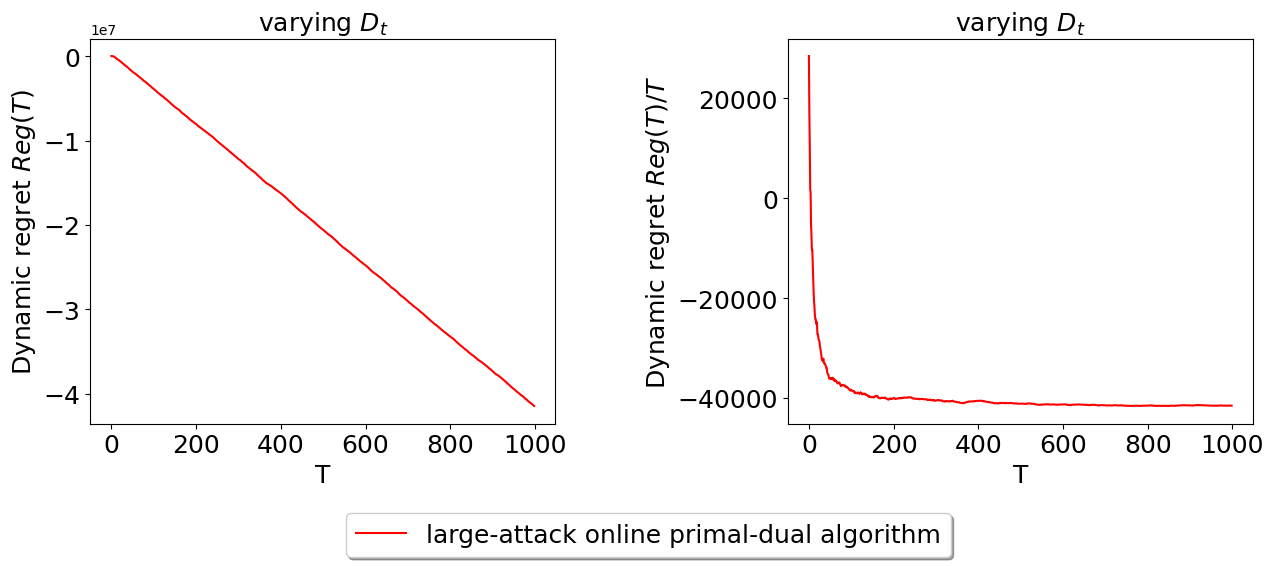

In [14]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret,color = 'red',linewidth = '1.5',label='large-attack online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret_T,color = 'red',linewidth = '1.5',label='large-attack online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))

#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.png',format='png', bbox_inches='tight')

In [15]:
#累计的约束违反

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [17]:
sum_thermal_wind_power_station_strategy=np.loadtxt("./data/01_large_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt")
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(100,10).txt")

In [18]:
accumulative_constraint_violation=[]
accumulative_constraint_violation_T=[]
for T in range(1, 1000):
    accumulative_constraint_violation_auxiliary_variable=0
    for t in range(0, T): 
        accumulative_constraint_violation_auxiliary_variable=accumulative_constraint_violation_auxiliary_variable+(1/58)*sum_thermal_wind_power_station_strategy[t+1]-d_power_demand[t+1]
    accumulative_constraint_violation.append(abs(accumulative_constraint_violation_auxiliary_variable))
    accumulative_constraint_violation_T.append(abs(accumulative_constraint_violation_auxiliary_variable)/T)

In [19]:
accumulative_constraint_violation

[26.384981014827588,
 31.74391908965518,
 28.625608670344832,
 4.4135572574138,
 1.854162590344842,
 34.68968538499999,
 56.3184471789655,
 89.14443736931032,
 101.2042258977586,
 140.0825389289655,
 180.53563849189652,
 232.43884355793102,
 278.69115435206896,
 317.4117159924138,
 366.12531889689654,
 406.2281055063793,
 434.9739822868965,
 479.05143239068957,
 500.7433961549999,
 535.0173507341378,
 606.0355755693103,
 638.2016624663792,
 680.8543889981032,
 727.362650500517,
 762.5969457753447,
 805.2129738906895,
 858.984468260517,
 907.5359028532757,
 954.5205067844826,
 1007.5296252953445,
 1066.9866842577583,
 1115.496719115172,
 1148.3761526062067,
 1199.842369069655,
 1217.9089582551724,
 1274.6862846141378,
 1326.509427097931,
 1366.7744921824137,
 1402.7441268672414,
 1453.4880676293105,
 1502.3802508532763,
 1551.51891202069,
 1590.757510676552,
 1662.7015195953452,
 1715.0802830417244,
 1763.9537833508625,
 1807.4800885517245,
 1863.9344314400003,
 1922.833987401552,
 1963

In [20]:
#绘图 accumulative_constraint_violation和accumulative_constraint_violation_T

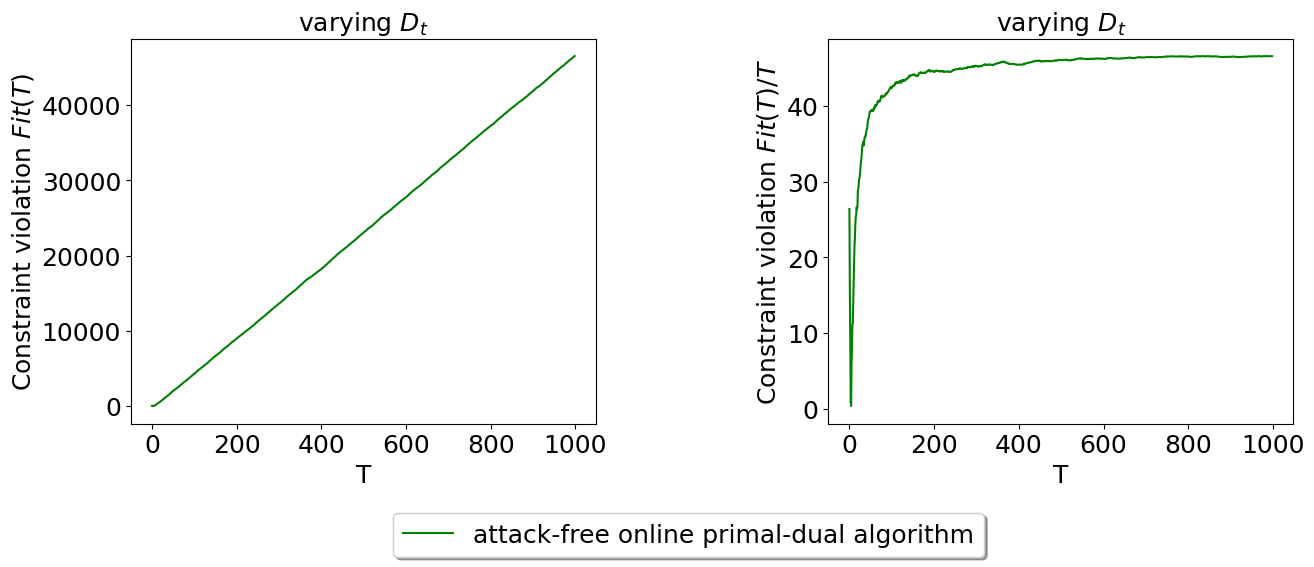

In [21]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation_T,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))


#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.png',format='png', bbox_inches='tight')